<a href="https://colab.research.google.com/github/p-rallapally/vignette-gnn/blob/main/vignette_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table 3 - Graph Neural Networks
## Molecular Property Prediction Example

### Intro

Graph Neural Networks (GNNs) leverage the ingenuity and layered infrastructure of traditional neural networks with graph data to derive insights from the relationships between different nodes and their connections. These networks operate either at a graph-level (producing a single embedding representative of the whole graph), a node-level (classifying/embedding individual nodes), or an edge-level (predicting relational properties). Depending on the intended purpose of a model and its given task, each level will garner a specific subset of information to learn from and derive unique insights. Harnessing the relational structure of this unique NN, each layer following the initial input embedding will aggregate information from neighboring nodes, allowing GNNs to better understand global graph topology and hierarchical data structuring. In order to combat the violation of sample independence in many-real world datasets, GNNs outperform traditional machine learning algorithms in capturing relational dependencies in datasets across several domains like NLP, computer vision, social networks, and molecular biology.

In our demonstration, GNNs will be applied in the realm of molecular biology, specifically predicting a molecule's ability to permeate the Blood-Brain barrier based on its chemical structure. This binary classification task pairs incredibly well with the capabilities of GNNs as its fundamental processes directly apply to understanding the relational structures of graphed molecules in the central nervous system. Given the great physical variation of these molecular structures, the amount of chemical dependence upon neighboring chemicals, and pure expense of lab equipment in real-time analysis, GNNs offer accurate predictions with a fraction of a pharmaceutical lab's cost. 

\* Our dataset is from the following repository: https://github.com/GLambard/Molecules_Dataset_Collection. 

\*\* Please note that due to the nature of chemprop's training process, the outputs of the training and prediction code blocks will be quite long. Feel free to scroll past them, but they are helpful to read if debugging errors when creating your own chemprop model.

First, we will set up our environment by importing necessary packages. `chemprop` is the core library, specializing in training GNNs for molecular property prediction, while the others are standard for data manipulation, visualization, and dividing data into training and testing sets.

In [ ]:
#!pip install chemprop
# import packages
import chemprop #chemprop package can train GNNs for molecule property prediction
import pandas as pd #for data viz
import numpy as np #
from sklearn.model_selection import train_test_split

Before training the GNN, the data must be prepared. We use the BBBP (Blood-Brain Barrier Penetration) dataset, a common benchmark in chemoinformatics, which is a binary classification task (predicting if a molecule can cross the blood-brain barrier). We clean the data by filtering out any obvious outliers (individually phased out in the code below).  

We define our features as such: `smiles` is a textual representation of a molecule's structure, which will be translated to a graph by `chemprop`. `p_np` indicates whether or not the molecule has the desired property (1) or not (0).

We then do an 80/20 split between training and testing, which is fairly standard, and convert the results into .csv files.

In [ ]:
# Clean data and make test train splits
bbbp_raw = pd.read_csv('data/raw/BBBP.csv')
bbbp_raw = bbbp_raw.sample(1000, random_state=42) #get a smaller sample of the largest dataset, it is sufficient to train a model with good accuracy
bbbp_raw = bbbp_raw[bbbp_raw['num'] != 616] #bad data
bbbp_raw = bbbp_raw[bbbp_raw['num'] != 60] #bad data
X, y = bbbp_raw['smiles'], bbbp_raw['p_np'] #x/features: molecule smiles, y/target: 1 for if the molecule has BBB property of interest, 0 if not
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#delineates training/testing data
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv('data/processed/train.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)

`chemprop train` is the module that will train the GNN. The code below specifies the training data, indicates a binary classification task, sets the directory where the trained model checkpoints and configurations will be saved, and defines 15 "epochs", or the number of training passes over the entire dataset.


As you scroll down, you'll see a lot of space taken up by the progress and results of each of the epochs as they are progressing through the dataset. You'll also see some code at the bottom indicated that the results were successfully stored in the model_checkpoints folder (woo!).

In [ ]:
# train chemprop model
!chemprop train --data-path data/processed/train.csv \
                 --task-type classification \
                 --output-dir model_checkpoints/bbbp_checkpoints \
                 --epochs 15

2025-12-02T09:56:23 - INFO:chemprop.cli.main - Running in mode 'train' with args: {'smiles_columns': None, 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'config_path': None, 'data_path': PosixPath('data/processed/train.csv'), 'output_dir': PosixPath('model_checkpoints/bbbp_checkpoints'), 'remove

After training is complete, we use the best-performing model checkpoint to make predictions on the held-out test set `test.csv`. This set was not seen during training, providing an unbiased evaluation of the model's generalization ability.

As for the paths:

`--model-path`: Specifies the path to the best-performing checkpoint file saved during the training step (identified by its lowest validation loss).

`--test-path`: Specifies the path to the independent test data.

`--preds-path`: Defines the path to save the resulting predictions. This CSV file will contain the molecule SMILES strings, the true labels, and the model's predicted probability for each class.

In [ ]:
# predict with chemprop model
!chemprop predict --model-path model_checkpoints/bbbp_checkpoints/model_0/checkpoints/best-epoch=14-val_loss=0.45.ckpt \
                 --test-path data/processed/test.csv \
                 --preds-path data/processed/test_predictions.csv


2025-12-02T09:58:50 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': None, 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'test_path': PosixPath('data/processed/test.csv'), 'output': PosixPath('data/processed/test_predictions.csv'), 'drop_extra_columns': False, '

Finally, we can evaluate the performance of the model using standard machine learning metrics (ROC/AUC). `pyplot` will visualize the data, and the other functions from sklearn.metrics will calculate the metrics.

`roc_curve` calculates the True Positive Rate (TPR) against the False Positive Rate (FPR) at various probability thresholds.

`roc_auc_score` calculates the AUC, which is a single-number summary of the model's performance across all possible classification thresholds.

Towards the end, ROC curve is plotted, comparing the GNN's performance against a random classifier (the "No Skill" line), and the AUC score is displayed in the legend.

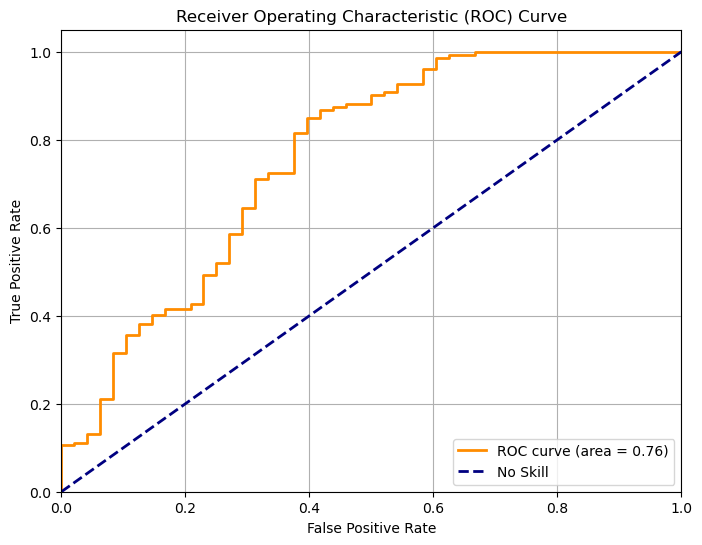

In [ ]:
# evaluate model with ROC AUC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

preds = pd.read_csv('data/processed/test_predictions.csv')

#C alculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(preds['p_np'], preds['pred_0'])

# Calculate the Area Under the Curve (AUC)
roc_auc = roc_auc_score(preds['p_np'], preds['pred_0'])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill') # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Graph Neural Networks (GNNs) offer a powerful way to learn directly from molecular graph structures, allowing models to capture interactions that traditional feature-based methods often overlook. In this vignette, we walked through the full workflow of preparing molecular data, training a Chemprop-style GNN for BBB permeability prediction, and evaluating its performance using ROC/AUC metrics. Our final model achieved an ROC-AUC of 0.76, indicating that the GNN was able to learn meaningful structural patterns and distinguish BBB-permeable from non-permeable molecules with reasonable accuracy.

These results show that graph-based models are well-suited for molecular property prediction tasks where structural information plays a key role. By leveraging the graph topology rather than relying solely on handcrafted features, GNNs provide a more flexible and expressive approach to modeling molecular behavior. The pipeline demonstrated here can be extended to larger datasets, different molecular endpoints, or more advanced GNN architectures as future work.

Overall, this project highlights the effectiveness of GNNs in capturing chemical relationships and demonstrates how graph-based learning can improve predictive modeling in molecular applications.